In [1]:
cd ../pytorch/

/Users/trentonbricken/protein-gen/pytorch


## Loading in model and setting protein length

In [2]:
import numpy as np
import matplotlib
import platform
if platform.system() == 'Darwin':
    matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch
import datetime

import time
import pickle
import os

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

import seaborn as sns
import matplotlib.pylab as plt
from scipy.special import softmax
import json

from EVCouplingsGen import *
from evcouplings.couplings import CouplingsModel
from EVCouplingsStuff.seq_sele import *

from metropolis import MetropolisHastings
from utils import *

from nflib.MADE import *
from nflib.flows import *
from nflib.spline_flows import NSF_AR, NSF_CL
import itertools

In [3]:
protein_length =6
is_discrete = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading in EVCouplings model 
focus_seqs = read_fa('EVCouplingsStuff/DYR_ECOLI_1_b0.5.a2m_trimmed.fa')
evc_model = CouplingsModel('EVCouplingsStuff/DYR.model')

# extracting the model parameters used to determine the evolutionary hamiltonian
h = evc_model.h_i
J = evc_model.J_ij

if protein_length > 0:
    h = h[0:protein_length, :]
    J = J[0:protein_length, 0:protein_length, :,:]

# processing and plotting the natural sequences: 
# first by converting amino acids into integers and also onehots. 
enc_seqs=[]
oh = []
AA=h.shape[1] # number of amino acids
for seq in focus_seqs['seq']:
    enc_seq = np.asarray(encode_aa(seq, evc_model.alphabet_map))
    if protein_length > 0: 
        enc_seq = enc_seq[:protein_length]
    enc_seqs.append(enc_seq) 
    oh.append(onehot(enc_seq,AA)) # this could be made much more efficient with tensorflow operations. 
enc_seqs = np.asarray(enc_seqs)
oh=np.asarray(oh) # of shape: [batch x L x AA]
N = oh.shape[0] # batch size
L = oh.shape[1] # length of the protein

print('number and dimensions of the natural sequences', oh.shape)

# loading in the environment class, used to score the evolutionary hamiltonians
gen_model = EVCouplingsGenerator(L, AA, h, J, device, is_discrete, gaussian_cov_noise = 1.0)



number and dimensions of the natural sequences (7848, 6, 20)


Plotting a hist of all the natural sequences energies:


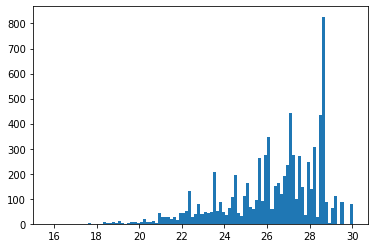

In [4]:
nat_energies = hamiltonians(oh, J, h)
%matplotlib inline
plt.figure()

print('Plotting a hist of all the natural sequences energies:')
plt.hist(nat_energies, bins=100)
plt.show()

In [5]:
np.max(nat_energies)

30.02301879413426

## Running MCMC

In [6]:


nsteps = 30000
sampler = MetropolisHastings(gen_model, noise=5.0, 
                     stride=5, mapper=None, 
                     is_discrete=True, AA_num=AA)
#mapper=HardMaxMapper() but now I have discrete actions so dont need. 
sample_x = sampler.run(nsteps)

In [7]:
sample_x.shape

(384000, 120)

Plotting a hist of all the natural sequences energies:


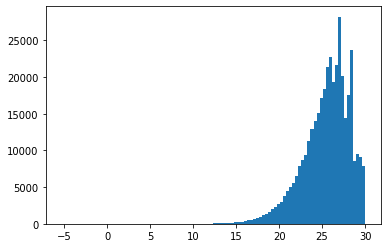

In [8]:
energy_x = hamiltonians(sample_x, J, h)
%matplotlib inline
plt.figure()

print('Plotting a hist of all the natural sequences energies:')
plt.hist(energy_x, bins=100)
plt.show()

In [9]:
np.max(energy_x)

30.02301879413426

## Quantifying diversity and score metrics

In [10]:
def hard_max(inp):
    if inp.shape[1] > L: # if it isnt a sequence of ints, then all to one hot.  
        #print('the input to oh is', inp)

        if len(inp)>2:
            inp = inp.reshape(inp.shape[0], -1, 20)
        else:
            inp = inp.reshape(-1,20)

        inp = np.argmax(inp, axis=-1)
    return inp

In [11]:
x = hard_max(sample_x)
x.shape

(384000, 6)

In [12]:
x

array([[13,  7, 17, 15,  7,  3],
       [ 9,  9,  4,  6, 15, 11],
       [10, 10,  6,  2, 19, 14],
       ...,
       [ 0,  7,  7,  0,  0, 17],
       [ 8,  0,  7,  0,  0,  7],
       [15, 10,  7, 17,  0, 17]])

In [13]:
enc_seqs

array([[15,  9,  7,  0,  0,  9],
       [11,  9, 17, 17,  0,  0],
       [13,  7,  7, 17,  0,  9],
       ...,
       [16,  9,  7,  0,  0, 17],
       [ 1,  9,  7,  0,  0,  0],
       [16,  7,  7,  7,  0,  0]])

In [14]:
n2a = dict([(n, a) for a, n in gen_model.a2n.items()])  
n2a

{0: 'A',
 1: 'C',
 2: 'D',
 3: 'E',
 4: 'F',
 5: 'G',
 6: 'H',
 7: 'I',
 8: 'K',
 9: 'L',
 10: 'M',
 11: 'N',
 12: 'P',
 13: 'Q',
 14: 'R',
 15: 'S',
 16: 'T',
 17: 'V',
 18: 'W',
 19: 'Y'}

In [15]:
def n_to_aa(inp):
    to_aa = []
    N=20 # none of these focus have gaps, else should be 21. 
    for seq in inp:
        st = ''
        for s in seq:
            st+= n2a[s]
        to_aa.append(st)
    to_aa=np.asarray(to_aa)
    return to_aa

In [16]:
## downsize the x's

num_samps = 10000

rands = np.random.randint(0, x.shape[0], size=num_samps)
x = x[rands]
energy_x = energy_x[rands]

In [17]:
x.shape

(10000, 6)

generated


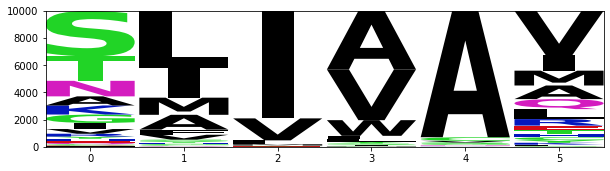

real


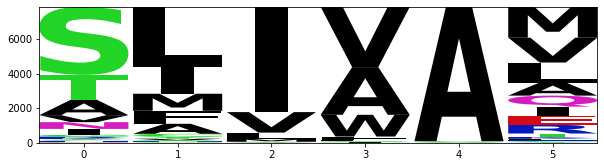

In [18]:
import logomaker as lm
names = ['generated', 'real']
for data, n in zip([x, enc_seqs], names):
    print(n)
    to_aa = n_to_aa(data)
    counts_mat = lm.alignment_to_matrix(to_aa)
    lm.Logo(counts_mat[0:50])
    plt.show()

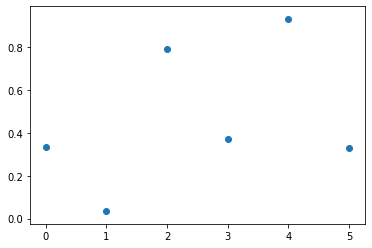

In [19]:
# sequence logo but in percentage and anchored to a particular sequence

ind = 0 # particular sequence thats the anchor. 
plt.scatter(np.arange(x.shape[1]),(x[ind,:] == x).sum(axis=0)/x.shape[0])

In [20]:
from scipy.spatial.distance import hamming
hamming([0, 0, 0], [0, 0, 0])

0.0

In [21]:
# higher the value the further away they are. it is a distance after all

========= showing!  generated
selecting  100  for faster computation
(100, 100)
mean hamming 0.4019333333333333


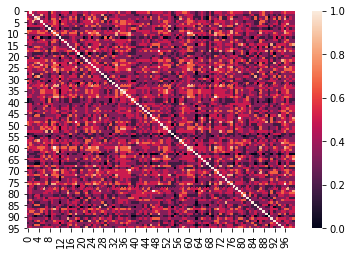

========= showing!  real
selecting  100  for faster computation
(100, 100)
mean hamming 0.4362666666666667


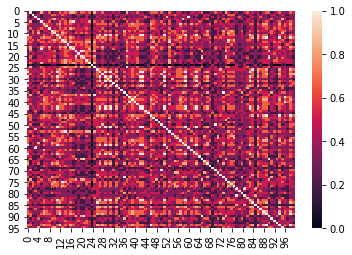

In [22]:
from scipy.spatial.distance import hamming, pdist, squareform
n_rand =100
names = ['generated', 'real']
for data, n in zip([x, enc_seqs], names):
    print('========= showing! ', n)
    
    print('selecting ', n_rand,' for faster computation')
    rand_inds =np.random.choice(np.arange(data.shape[0]), n_rand, replace=False)
    data = data[rand_inds, :]
    
    ham = 1- squareform(pdist(data, hamming))
    print(ham.shape)
    print('mean hamming', ham.mean())
    sns.heatmap(ham)
    plt.show()

# Looking at the similarities with MSA weights

In [23]:

gen_w, gen_neighbors = msa_weights(x, theta=0.8, pseudocount=0) # higher the theta the more closely they need to be related. 
w, neighbors = msa_weights(enc_seqs, theta=0.8, pseudocount=0)

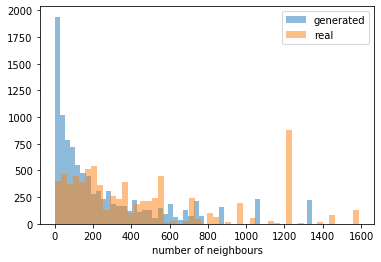

In [24]:

# number of neighours with a hamming above the theta value. 
plt.hist(gen_neighbors, bins=50, alpha=0.5, label='generated')
plt.hist(neighbors, bins=50, alpha=0.5, label='real')
plt.xlabel('number of neighbours')
plt.legend()

In [25]:
# combining natural and generated to see what diversity is maintained

comb_gen_nat= np.concatenate([x, enc_seqs], axis=0)
w_comb, n_comb = msa_weights(comb_gen_nat, theta=0.5, pseudocount=0)

9614


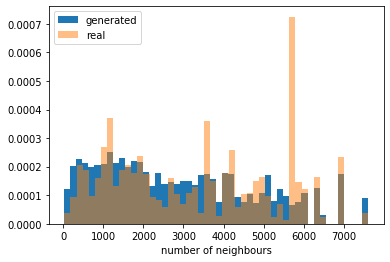

In [26]:
energy_cut = 20
num_x_kept = x[np.where(energy_x > energy_cut)].shape[0]
print(num_x_kept)
comb_fitgen_nat= np.concatenate([x[np.where(energy_x > energy_cut)], enc_seqs], axis=0)
w_combf, n_combf = msa_weights(comb_fitgen_nat, theta=0.6, pseudocount=0)

fig, ax = plt.subplots(1)
ax.hist(n_combf[:num_x_kept], bins=50, density=True, label='generated');
ax.hist(n_combf[num_x_kept:], bins=50, alpha=0.5, density=True, label='real');
plt.xlabel('number of neighbours')
plt.legend()
plt.show()

In [27]:
gen_w, gen_neighbors = msa_weights(x, theta=0.8, pseudocount=0) # higher the theta the more closely they need to be related. 
w, neighbors = msa_weights(enc_seqs, theta=0.8, pseudocount=0)

(array([5023., 1749.,  941.,  661.,  531.,  492.,  153.,  231.,    0.,
         219.]),
 array([1.0000e+00, 1.3520e+02, 2.6940e+02, 4.0360e+02, 5.3780e+02,
        6.7200e+02, 8.0620e+02, 9.4040e+02, 1.0746e+03, 1.2088e+03,
        1.3430e+03]),
 <a list of 10 Patch objects>)

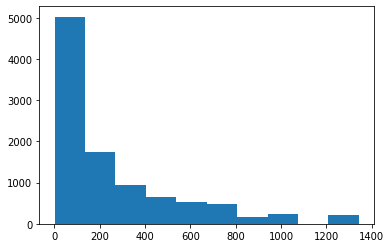

In [28]:
plt.hist(gen_neighbors)

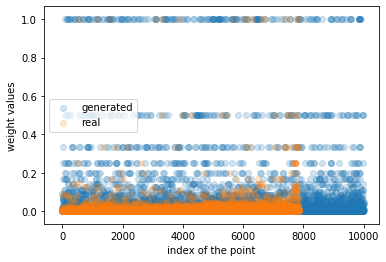

In [29]:
plt.scatter(np.arange(gen_w.shape[0]), gen_w,  alpha=0.2, label='generated')
plt.scatter(np.arange(w.shape[0]), w, alpha=0.2, label='real')
plt.ylabel('weight values')
plt.xlabel('index of the point')
plt.legend()

### UMAP the sequences to see how they cluster

In [30]:
import umap
import seaborn as sns
# sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
reducer = umap.UMAP()

In [108]:
# converting the generated into a onehot: 
N= 20 # num of amino acids
x_oh = onehot(x, N)
x_oh= x_oh.reshape((x.shape[0], -1))
x_oh.shape

(10000, 120)

In [109]:
enc_oh = onehot(enc_seqs, N)
enc_oh= enc_oh.reshape((enc_oh.shape[0], -1))
enc_oh.shape

(7848, 120)

In [110]:
to_u = np.vstack([x_oh, enc_oh])
u_type = np.vstack([np.ones((x_oh.shape[0], 1)), np.zeros((enc_oh.shape[0], 1))])
print(to_u.shape, u_type.shape)

(17848, 120) (17848, 1)


In [111]:
reducer.fit(enc_oh)

/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [112]:
embedding = reducer.transform(to_u)
embedding.shape


/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap

(17848, 2)

In [113]:
u_type = list(u_type)
len(u_type)

17848

In [114]:
sns.color_palette()[1]

(1.0, 0.4980392156862745, 0.054901960784313725)

In [115]:
nat_energies.mean()

26.337598889962614

In [116]:
num_gen = x.shape[0]
num_gen

10000

### Generated vs real sequences

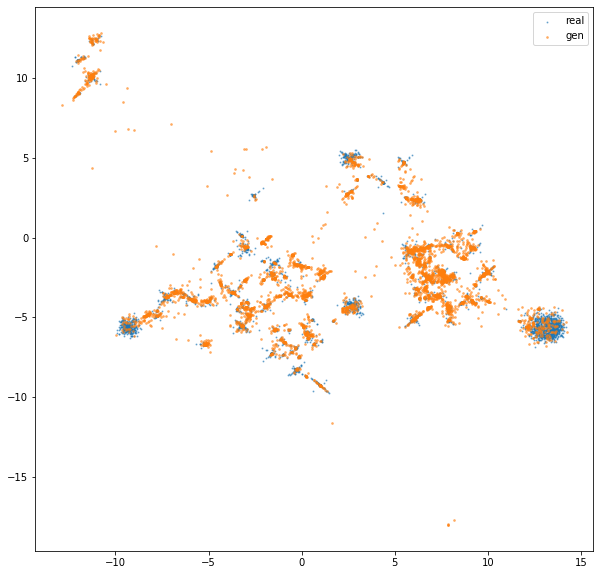

In [118]:
E = 26
#plt.title('UMAP projection of the Generated and Natural Proteins', fontsize=24);
plt.scatter(embedding[num_gen:, 0][nat_energies>E], embedding[num_gen:, 1][nat_energies>E], s=1, alpha=0.5, label='real')
plt.scatter(embedding[0:num_gen, 0][energy_x > E], embedding[0:num_gen, 1][energy_x > E], s=3, alpha=0.5, label='gen')
plt.gcf().set_size_inches(10,10)
plt.legend();

In [ ]:
[sns.color_palette()[int(e)] for e in es]

### Scores of the sequences

In [120]:
all_energies = np.hstack([energy_x, nat_energies])

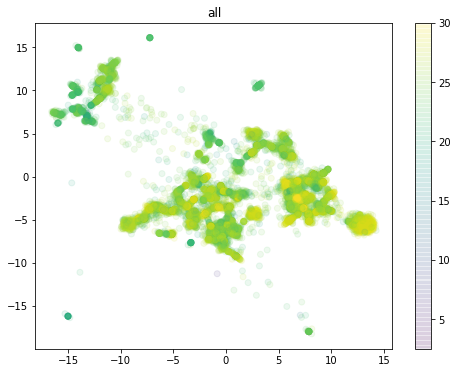

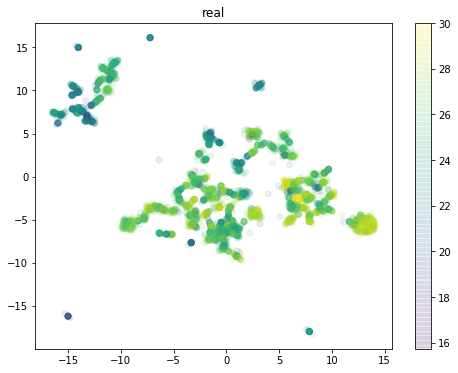

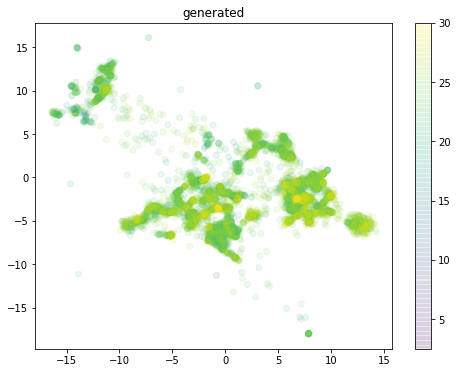

In [130]:
for seqs_and_es_to_plot, title in zip([(embedding, all_energies ), (embedding[num_gen:, :], nat_energies), 
                                       (embedding[0:num_gen,:], energy_x) ], ['all', 'real', 'generated']):
    seqs_to_plot, es = seqs_and_es_to_plot
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.scatter(seqs_to_plot[:, 0], seqs_to_plot[:, 1], c=es, alpha=0.1)
    plt.colorbar()

## Cluster calculation

In [137]:
def single_ham(seq, mat):
    return 1 - ((seq == mat).sum(-1) / len(seq))

In [158]:
import copy
def score_diversity_metric(seqs, energies, theta, E_min):
    gen_w, gen_neighbors = msa_weights(seqs, theta=theta, pseudocount=0)
    Neff = gen_w.sum()
    
    sort_ind = np.argsort(-energies ) # sort descending
    e_sorted = energies[sort_ind]
    x_sorted = seqs[sort_ind]
    
    
    unique_peaks = []
    unique_seqs = []
    x_greedy = copy.copy(x_sorted)
    e_greedy = copy.copy(e_sorted)
    E_min = np.min(nat_energies)
    while e_greedy[0] >= E_min: # way this works is that we remove everything nearby and keep taking off the top of the remaining 
        # elements from the sorted list. 
        unique_peaks.append(e_greedy[0])
        unique_seqs.append(x_greedy[0])
        hams = single_ham(x_greedy[0], x_greedy) #NB this will eliminate itself.
        x_greedy = x_greedy[hams>=theta] # keeps only the sequences that are far away.  
        e_greedy = e_greedy[hams>=theta]
        
        if len(e_greedy) == 0: # in case everything is removed. 
            break
        
    return Neff, unique_seqs, unique_peaks
    

    

In [159]:
E_min = np.min(nat_energies)

Neff, unique_seqs, unique_peaks = score_diversity_metric(x, energy_x, theta, E_min)

print(Neff, unique_peaks)

517.0476195000598 [30.02301879413426, 26.83137374301441, 22.49803032912314, 21.558416789164767, 18.91488445084542, 17.886200225912035, 16.911772895604372, 16.823631640989333]


## UMAP the peaks found. 

In [98]:
to_embed = np.vstack([x, np.asarray(unique_seqs)])

In [101]:
x_oh = onehot(to_embed, N)
x_oh= x_oh.reshape((x_oh.shape[0], -1))
x_oh.shape

(10008, 120)

In [102]:
reducer.fit(x_oh)
embedding = reducer.transform(x_oh)

/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


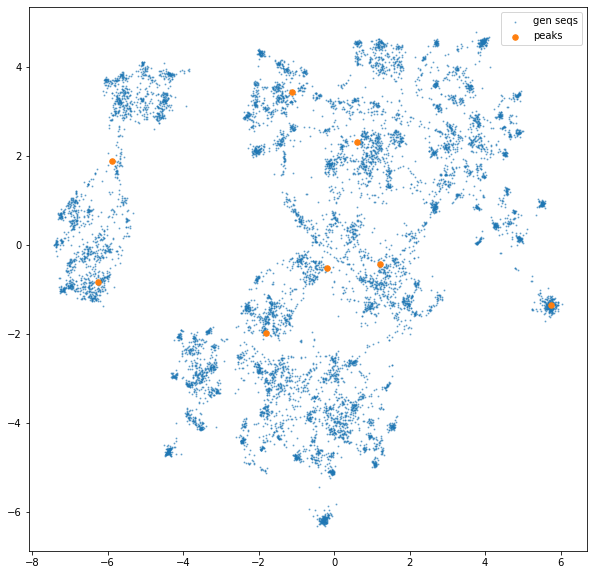

In [107]:
num_peaks = len(unique_seqs)

plt.scatter(embedding[0:-num_peaks, 0], embedding[0:-num_peaks, 1], s=1, alpha=0.5, label='gen seqs')
plt.scatter(embedding[-num_peaks:, 0], embedding[-num_peaks:, 1], s=30, alpha=1.0, label='peaks')
plt.gcf().set_size_inches(10,10)
plt.legend();

## Peak Comparison of natural to generated

In [165]:
# generated
Neff, unique_seqs, unique_peaks = score_diversity_metric(x, energy_x, theta, E_min)

print('Neff:', Neff, 'unique peak num', len(unique_peaks))
print('unique peak sums', sum(unique_peaks))

Neff: 517.0476195000598 unique peak num 8
unique peak sums 171.44732886878774


In [166]:
# real

Neff, unique_seqs, unique_peaks = score_diversity_metric(enc_seqs, nat_energies, theta, E_min)

print('Neff:', Neff, 'unique peak num', len(unique_peaks))
print('unique peak sums', sum(unique_peaks))

Neff: 88.33717321378161 unique peak num 5
unique peak sums 115.68797558231745
